In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# model path
archive_path = '../../archive/model_spacy_processing_ldaonly_dictchange/'

In [2]:
# load dict and doc term matrixes
import pickle
obj_name_list = [
    'id2word', 
    'doc_term_matrix', 
    'doc_term_matrix_random_projections', 
    'doc_term_matrix_tfidf', 
    'doc_term_matrix_logentropy'
]
obj_list = []
for name in obj_name_list:
    with open(f'{archive_path}/model-server/dict_and_matrix/{name}.pkl', 'rb') as f:
        obj = pickle.load(f)
        obj_list.append(obj)
        print(obj)

Dictionary(10770 unique tokens: ['great', 'lunch', 'maui', 'ocean', 'overlook']...)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
filepath_hi = f'{archive_path}/data-server/processed/hi_rws_0001_0256_topics.csv'
df = pd.read_csv(filepath_hi)
models_list = [i.split('_topic_mode')[0] for i in df.columns if i.endswith('topic_mode')]
models_list

['lda_5', 'lda_logentropy', 'lda_tfidf']

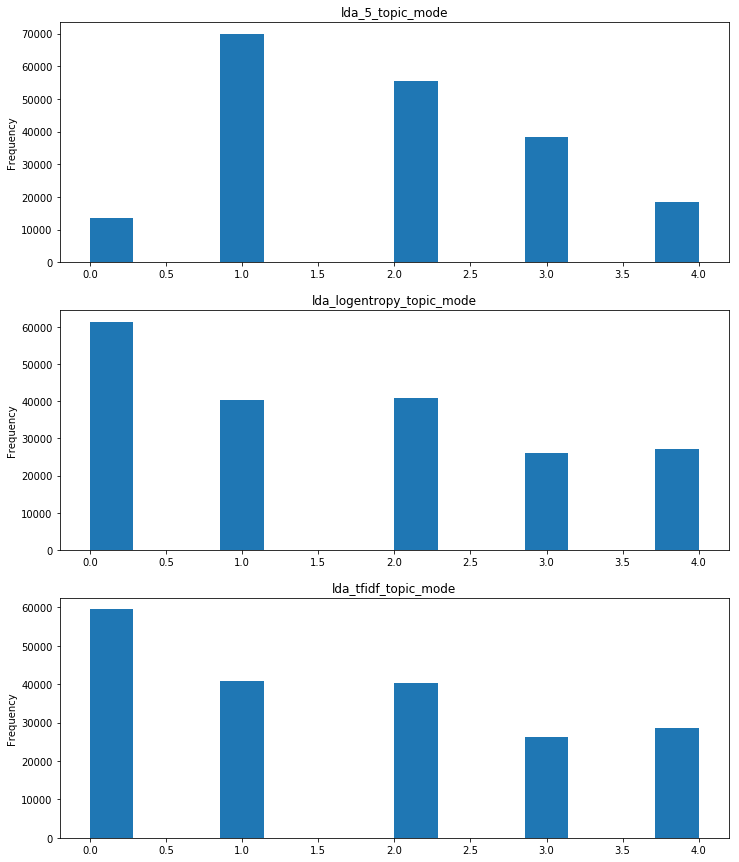

In [9]:
# topics value distribution
column_names = [i for i in df.columns if i.endswith('_mode')]
subplot_indexes = range(len(column_names))
fig, axes = plt.subplots(len(column_names), 1, figsize=(12,15))
for column_name, subplot_index in zip(column_names, subplot_indexes):
    index_row = 0 if subplot_index % 2 == 0 else 1
    df.loc[:,column_names[subplot_index]].plot(kind='hist', bins=14, ax=axes[subplot_index], title=column_name)

In [4]:
from gensim.models import LdaModel, LsiModel
from gensim.corpora import Dictionary
import itertools

loaded_models_list = []

for index, model in enumerate(models_list):
    model_path = f'{archive_path}/model-server/{model[:3]}_model/{model}.model'
    loaded_model = LdaModel.load(model_path) if model[:3] == 'lda' else LsiModel.load(model_path)
    print(f'{index}: <', loaded_model)
    loaded_models_list.append(loaded_model)

0: < LdaModel(num_terms=10770, num_topics=5, decay=0.5, chunksize=2000)
1: < LdaModel(num_terms=10770, num_topics=5, decay=0.5, chunksize=2000)
2: < LdaModel(num_terms=10770, num_topics=5, decay=0.5, chunksize=2000)


## Selected Model

In [41]:
# rest of the code depends on here.
topic_model=loaded_models_list[0]
topic_mode_selected = df.lda_5_topic_mode
topic_mode_prob_selected = df.lda_5_topic_mode_prob
corpus=obj_list[1] #debug only, [:5000]
dictionary=obj_list[0]

In [ ]:
# make a dataframe from words
topic_words = topic_model.show_topics(num_words=300, formatted=False)

topics_list = []
for (topic, word_list) in topic_words:
    temp = pd.DataFrame(word_list, columns=[f'{topic}_word', f'{topic}_prob'])
    topics_list.append(temp)
pd_topics = pd.concat(topics_list, axis=1)
pd_topics.to_csv(f'{archive_path}/data-server/processed/hi_rws_0001_0256_topics_words.csv', index=False)
pd_topics.head(10)

In [ ]:
# words in the topics for selected model
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

for i in range(len(topics_list)):
    wordcloud = WordCloud(
            background_color='white',
            # stopwords=stopwords,
            max_words=400,
            max_font_size=40, 
            scale=5,
            random_state=1 # chosen at random by flipping a coin; it was heads
        ).generate(str(pd_topics[f'{i}_word']))
    wordcloud.to_file(f'{archive_path}/data-server/processed/hi_rws_0001_0256_topic_{i}.png')
    fig = plt.figure(1, figsize=(6, 6), dpi=100)    
    fig.suptitle(f'topic_{i}', fontsize=25)
    fig.subplots_adjust(top=2.3)
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

In [ ]:
# topic sent distribution per review
pd_topic_frequencies = topic_mode_prob_selected.apply(lambda x: pd.Series(x.split(',')).value_counts())
pd_topic_frequencies = pd_topic_frequencies.fillna(0).reindex(columns=sorted(pd_topic_frequencies))
pd_topic_frequencies.columns = [f'topic_{i}' for i in range(5)]
pd_topic_frequencies.head()

In [ ]:
# dump final data
data_path = f'{archive_path}/data-server/processed/hi_rws_0001_0256_descriptive.csv'
sentiments_path = f'{archive_path}/data-server/processed/hi_rws_0001_0256_sentiments.csv'
df1 = pd.read_csv(data_path)
df2 = pd.read_csv(sentiments_path)

# needed fixes
df1 = df1.drop([13914, 107036, 114094], axis=0)
df1.index = df1.reset_index(drop=True).index
topic_mode_selected.name = 'topic_score'
df2['sgd.1'].name = 'sentiment_score'

df_final = pd.concat([df1, pd_topic_frequencies, topic_mode_selected, df2['sgd.1']], axis=1)
df_final.to_csv(f'{archive_path}/data-server/processed/hi_rws_0001_0256_final.csv', index=False)
df_final.info()

## Model Plots

In [56]:
# takes a lot of time...
# Get topic weights
topic_weights = []
for i, row_list in enumerate(topic_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.25]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)
arr.shape

(4986, 5)

In [64]:
# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca', perplexity=50, n_iter=600)
tsne_lda = tsne_model.fit_transform(arr)
tsne_lda.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4986 samples in 0.002s...
[t-SNE] Computed neighbors for 4986 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4986
[t-SNE] Computed conditional probabilities for sample 2000 / 4986
[t-SNE] Computed conditional probabilities for sample 3000 / 4986
[t-SNE] Computed conditional probabilities for sample 4000 / 4986
[t-SNE] Computed conditional probabilities for sample 4986 / 4986
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.841805
[t-SNE] KL divergence after 600 iterations: 0.490350


(4986, 3)

In [72]:
mycolors

array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'], dtype='<U7')

In [83]:
import matplotlib.colors as mcolors
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, Legend
from bokeh.io import output_notebook

# vars
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

# plot
plot = figure(title="T-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=900)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

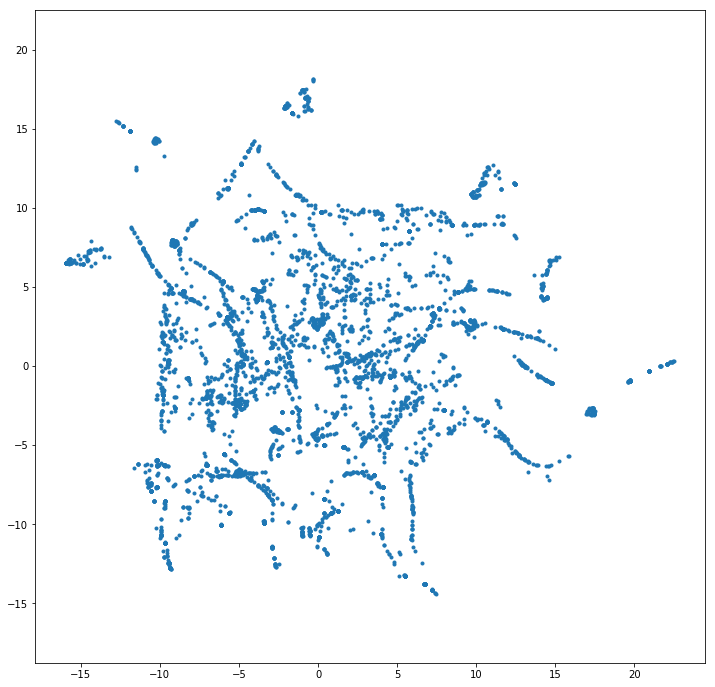

In [85]:
from matplotlib import cm
plt.figure(figsize=(12, 12))
plt.scatter(tsne_lda[:,0],tsne_lda[:,1], marker='.', cmap=cm.Paired)
plt.axis('equal')
plt.show()

In [79]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=topic_model, corpus=corpus, dictionary=dictionary)
vis

/Applications/anaconda3/envs/text/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.014239  0.018650       1        1  27.908220
1     -0.218589  0.010576       2        1  23.814312
4     -0.249510  0.112945       3        1  18.795193
3      0.324919  0.247776       4        1  15.431683
0      0.128941 -0.389946       5        1  14.050598, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
45    Default   72.000000         food   72.000000  30.0000  30.0000
16    Default  101.000000         good  101.000000  29.0000  29.0000
0     Default   58.000000        great   58.000000  28.0000  28.0000
32    Default   40.000000      service   40.000000  27.0000  27.0000
86    Default   31.000000         make   31.000000  26.0000  26.0000
10    Default  164.000000         have  164.000000  25.0000  25.0000
12    Default   55.000000        place   55.000000  24.0000  24.0000
2     Default   33.000000         maui   33.000000  23.0000  23.0000
89    Default   30.000000         time   30.000000  22.0000  22.0000
216   Default   19.000000      amazing   19.000000  21.0000  21.0000
44    Default   22.000000         view   22.000000  20.0000  20.0000
127   Default   25.000000        would   25.000000  19.0000  19.0000
15    Default   28.000000         fish   28.000000  18.0000  18.0000
130   Default   20.000000        beach   20.000000  17.0000  17.0000
4423  Default   27.000000     lavender   27.000000  16.0000  16.0000
147   Default   37.000000        order   37.000000  15.0000  15.0000
135   Default   18.000000     friendly   18.000000  14.0000  14.0000
133   Default   17.000000       little   17.000000  13.0000  13.0000
209   Default   18.000000        price   18.000000  12.0000  12.0000
100   Default   32.000000         come   32.000000  11.0000  11.0000
29    Default   19.000000        enjoy   19.000000  10.0000  10.0000
23    Default   16.000000        drink   16.000000   9.0000   9.0000
51    Default   25.000000         nice   25.000000   8.0000   8.0000
236   Default   17.000000    beautiful   17.000000   7.0000   7.0000
47    Default   22.000000        fresh   22.000000   6.0000   6.0000
108   Default   19.000000         will   19.000000   5.0000   5.0000
435   Default   14.000000        worth   14.000000   4.0000   4.0000
208   Default   13.000000        staff   13.000000   3.0000   3.0000
779   Default   20.000000       burger   20.000000   2.0000   2.0000
27    Default   26.000000    delicious   26.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
96     Topic5    7.497753        sweet    7.498287   1.9624  -4.5135
297    Topic5    6.879296  reservation    6.879827   1.9624  -4.5996
94     Topic5    6.919140         rice    6.919676   1.9624  -4.5938
121    Topic5    6.853889      parking    6.854427   1.9624  -4.6033
1526   Topic5    5.390670        store    5.391216   1.9624  -4.8435
425    Topic5    5.263474         full    5.264009   1.9624  -4.8673
2403   Topic5    5.230130         road    5.230669   1.9624  -4.8737
1969   Topic5    5.284734         gift    5.285282   1.9624  -4.8633
629    Topic5    4.838705         free    4.839239   1.9624  -4.9515
9036   Topic5    5.013493        scone    5.014065   1.9624  -4.9160
1415   Topic5    4.532582         roll    4.533120   1.9624  -5.0168
791    Topic5    4.171637        yummy    4.172171   1.9624  -5.0998
3160   Topic5    4.203434    haleakala    4.203989   1.9624  -5.0922
87     Topic5    3.939435         pick    3.939975   1.9624  -5.1571
212    Topic5    3.837591        spend    3.838127   1.9624  -5.1833
3629   Topic5    4.059744        plant    4.060331   1.9624  -5.1270
1636   Topic5    3.689557         home    3.690095   1.9624  -5.2226
1558   Topic5    3.713478         rock    3.714021   1.9624  -5.2162
235    Topic5    3.526731       pricey    3.527263   1.9624 